# Survival examples

In this notebook, we walk through the different usages of the ICARE package for survival prediction tasks (or any ranking task with a censored target).

In [11]:
import numpy as np
from sksurv import datasets
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sksurv.util import Surv

from icare.visualisation import plot_avg_sign
from icare.metrics import harrell_cindex, harrell_cindex_scorer
from icare.survival import IcareSurvival, BaggedIcareSurvival

We use a dataset from scikit-survival.

In [12]:
X, y = datasets.load_veterans_lung_cancer()
X = OneHotEncoder().fit_transform(X)

C:\Users\louis\Documents\work\ICARE\venv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


Both `IcareSurvival` and `BaggedIcareSurvival` can be used like any other scikit-learn estimator.

In [13]:
model = IcareSurvival()
model.fit(X, y)
pred = model.predict(X)
print(pred[:5], harrell_cindex(y, pred))

model = BaggedIcareSurvival()
model.fit(X, y)
pred = model.predict(X)
print(pred[:5], harrell_cindex(y, pred))

[-0.86676945 -0.54714153 -1.89672184 -0.30465896 -0.34216859] 0.6669695592912313
[-0.97553991 -0.96223422 -1.12326956 -0.74229951 -0.86201233] 0.696501590186279


Then are compatible with any scikit-learn function.

In [14]:
print(cross_val_score(IcareSurvival(), X, y,
                      cv=ShuffleSplit(n_splits=4, test_size=.25, random_state=42),
                      n_jobs=-1,
                      scoring=harrell_cindex_scorer).mean())

print(cross_val_score(BaggedIcareSurvival(), X, y,
                      cv=ShuffleSplit(n_splits=4, test_size=.25, random_state=42),
                      n_jobs=-1,
                      scoring=harrell_cindex_scorer).mean())

0.6367912986203035
0.6679357053762346


The target value can be censored or not. If not censored, simply pass a 1D array.

In [15]:
# create the non censored target
target = np.array([x[1] for x in y])
event = np.array([x[0] for x in y])

print(target.shape)

(137,)


In [16]:
model = IcareSurvival()
model.fit(X, target)
pred = model.predict(X)
print(pred[:5], harrell_cindex(y, pred))

[-0.86676945 -0.54714153 -1.89672184 -0.30465896 -0.34216859] 0.6669695592912313


However, if it censored and you have two arrays: one for target, one for the censoring, you need to format them with the sickit-survival format.

In [17]:
y = Surv.from_arrays(event=np.array(event).astype('bool'), time=target)
y[:10]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.)],
      dtype=[('event', '?'), ('time', '<f8')])

In [18]:
model = IcareSurvival()
model.fit(X, y)
pred = model.predict(X)
print(pred[:5], harrell_cindex(y, pred))

[-0.86676945 -0.54714153 -1.89672184 -0.30465896 -0.34216859] 0.6669695592912313


For interpretation, you can use the `plot_avg_sign` function to plot the average signs of the features in the `BaggedIcareSurvival` model.

A positive sign means that the feature is anti-concordant with the target value (e.g. decreases time to death when value increases, meaning a higher risk), and the other way around for a negative sign. A value close to zero mean that the feature sign was unstable. This can be due to a low predictive power.

C:\Users\louis\Documents\work\ICARE\venv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


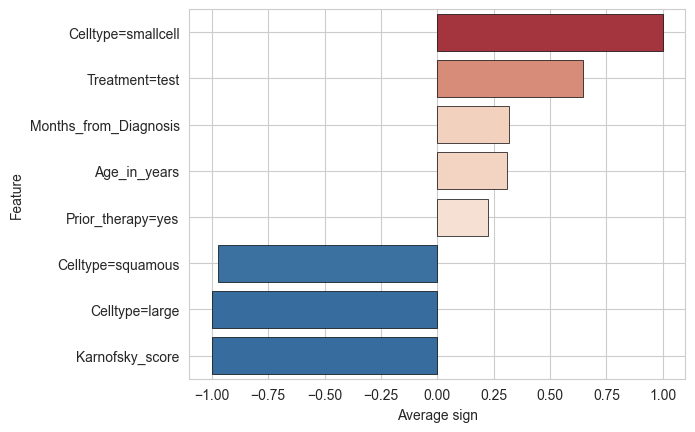

In [20]:
model = BaggedIcareSurvival(n_estimators=1000, n_jobs=-1)


X, y = datasets.load_veterans_lung_cancer()
X = OneHotEncoder().fit_transform(X)
model.fit(X,y)
plot_avg_sign(model)